In [62]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
import pandas as pd

import numpy as np
import os
import shutil
import posixpath
import wfdb
import seaborn as sn

In [85]:
# docs: https://wfdb.readthedocs.io/en/latest/wfdb.html
# SpO2が含まれているデータは a01r のようにrが付いている
# records

subjects = ['a01', 'a02', 'a03', 'a04', 'b01', 'c01', 'c02', 'c03']

records = {}

# データの読み込み
for subject in subjects:
    path = "dataset/" + subject + 'r'
    ecg_path = "dataset/" + subject

    records[subject + 'r'] = wfdb.rdrecord(path)  # 計測データ
    records['ecg_' + subject] = wfdb.rdrecord(ecg_path)  # ECGの計測データ
    records['ann_' + subject + 'r'] = wfdb.rdann(path, 'apn', shift_samps=True) # ラベル

# 波形を確認する
#record = wfdb.rdrecord('dataset/a01r')
#annotation = wfdb.rdann('dataset/a01r', 'apn')

#wfdb.plot_wfdb(record=record, title='Record a01', time_units='seconds', figsize=(20,10)) 
#display(records['a01r'].__dict__)

In [98]:
# https://archive.physionet.org/physiobank/database/apnea-ecg/annotations.shtml
# display(annotation.__dict__)
display(len(records['ann_a01r'].sample))
display(len(records['ann_a01r'].symbol))

3108000 / 6000
print(records['ann_a01r'].symbol)
display(records['ecg_a01'].__dict__)

489

489

['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',

{'record_name': 'a01',
 'n_sig': 1,
 'fs': 100,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 2957000,
 'base_time': None,
 'base_date': None,
 'comments': [],
 'sig_name': ['ECG'],
 'p_signal': array([[-0.06 ],
        [-0.065],
        [-0.06 ],
        ...,
        [ 0.   ],
        [ 0.   ],
        [ 0.   ]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['a01.dat'],
 'fmt': ['16'],
 'samps_per_frame': [1],
 'skew': [None],
 'byte_offset': [None],
 'adc_gain': [200.0],
 'baseline': [0],
 'units': ['mV'],
 'adc_res': [12],
 'adc_zero': [0],
 'init_value': [-12],
 'checksum': [5827],
 'block_size': [0]}

In [4]:
# print(record.p_signal.size)  # 4つの信号×時間 = サイズ
# 4信号で割ってアノテーションの個数で割ると大体6000sampleになる
# https://www.physionet.org/lightwave/?db=apnea-ecg/1.0.0 でテストデータを確認できる
# a03rの場合、08:37:50以降はアノテーションの記録がない

print(records['a01r'].p_signal.size / 4 / 489)

6046.617586912065


In [133]:
# 特徴量の抽出、学習用のデータ作成
# 1 sample(6000個のデータ)毎に基本統計量を出してそれをInputに与える
# 例) record.p_signal[0:6000], record.p_signal[6001:12001]で統計量を出す
        
def extract_feature(data):
    return np.hstack([data.mean().values, data.std().values, data.max().values, data.min().values, (data.max() - data.min()).values])

# train用
# 'b01r', 'c01r', 'c02r' はSpO2が0%のため除外、'c01r~c03rのデータはAのラベルが無い'
train_subjects = ['a01', 'a02', 'a04', 'c03']

# test用
test_subjects = ['a03']

data_array = []
for subject in train_subjects:
    # annotation分だけ繰り返す
    ann_count = len(records['ann_' + subject + 'r'].sample)
    data = pd.DataFrame(records[subject + 'r'].p_signal, columns=records[subject + 'r'].sig_name, dtype='float')

    # ECGの信号を追加する
    data['ECG'] = pd.DataFrame(records['ecg_' + subject].p_signal, columns=records['ecg_' + subject].sig_name, dtype='float')

    # Resp Nを消す
    data = data.drop('Resp N', axis=1)
    
    print('---train_subjects---')
    data['SpO2'] = (data['SpO2'] / 100)
    print(data.head())
    data = data.fillna(method='ffill') # 直前の値を使って欠損値埋める
    print(data.isnull().sum())

    # 基本統計量を出す
    # data.describe()
    # ピークの差 (data.max() - data.min()).values
    # np.hstack([data.mean().values, data.std().values, data.max().values, data.min().values])
    start_idx = 0
    end_idx = 6000
    for n in range(0, ann_count):
        data_array.append(extract_feature(data[start_idx:end_idx]))
        start_idx = end_idx + 1
        end_idx = end_idx + 6000

test_data = []
for subject in test_subjects:
    ann_count = len(records['ann_' + subject + 'r'].sample)
    data = pd.DataFrame(records[subject + 'r'].p_signal, columns=records[subject + 'r'].sig_name, dtype='float')
    
    # ECGの信号を追加する
    data['ECG'] = pd.DataFrame(records['ecg_' + subject].p_signal, columns=records['ecg_' + subject].sig_name, dtype='float')

    # Resp Nを消す
    data = data.drop('Resp N', axis=1)

    print('---test_subjects---')
    data['SpO2'] = (data['SpO2'] / 100)
    print(data.head())
    data = data.fillna(method='ffill') # 直前の値を使って欠損値埋める
    print(data.isnull().sum())
    start_idx = 0
    end_idx = 6000
    for n in range(0, ann_count):
        test_data.append(extract_feature(data[start_idx:end_idx]))
        start_idx = end_idx + 1
        end_idx = end_idx + 6000

---train_subjects---
   Resp C  Resp A          SpO2    ECG
0 -0.1015 -0.3446  9.800000e-07 -0.060
1 -0.1025 -0.3455  9.800000e-07 -0.065
2 -0.1035 -0.3464  9.800000e-07 -0.060
3 -0.1045 -0.3473  9.800000e-07 -0.075
4 -0.1055 -0.3482  9.800000e-07 -0.065
Resp C    0
Resp A    0
SpO2      0
ECG       0
dtype: int64
---train_subjects---
    Resp C   Resp A          SpO2    ECG
0 -0.08525  0.22005  9.600000e-07 -0.020
1 -0.08435  0.20915  9.600000e-07 -0.020
2 -0.08345  0.19830  9.600000e-07 -0.025
3 -0.08260  0.18740  9.600000e-07 -0.010
4 -0.08170  0.17655  9.600000e-07 -0.010
Resp C    0
Resp A    0
SpO2      0
ECG       0
dtype: int64
---train_subjects---
    Resp C   Resp A          SpO2    ECG
0 -0.14035 -0.14400  9.300000e-07 -0.105
1 -0.14060 -0.14650  9.300000e-07 -0.130
2 -0.14090 -0.14900  9.300000e-07 -0.110
3 -0.14120 -0.15155  9.300000e-07 -0.165
4 -0.14150 -0.15405  9.300000e-07 -0.320
Resp C    0
Resp A    0
SpO2      0
ECG       0
dtype: int64
---train_subjects---
    Res

In [134]:
# 学習データ作成
print(len(data_array))
train_X = np.array(data_array)

print(train_X[0].size)
print(train_X[1])
type(train_X)

train_X.shape

# テストデータ作成
print(len(test_data))
test_X = np.array(test_data)
test_X.shape

1963
20
[-5.64733956e-02 -4.05511169e-02  9.73498916e-07  7.42623771e-04
  5.26096529e-02  1.58064974e-01  6.78662729e-09  2.68905308e-01
  8.91000000e-02  5.25450000e-01  9.80000000e-07  1.74000000e+00
 -1.90200000e-01 -4.06650000e-01  9.60000000e-07 -9.00000000e-01
  2.79300000e-01  9.32100000e-01  2.00000000e-08  2.64000000e+00]
519


(519, 20)

In [135]:
# NとAを1,0に変換する
from sklearn.preprocessing import LabelEncoder

label_data = []
for subject in train_subjects:
    le = LabelEncoder()
    le = le.fit(records['ann_' + subject + 'r'].symbol)
    labels = le.transform(records['ann_' + subject + 'r'].symbol)
    label_data = np.concatenate([label_data, labels], 0)

# テスト用のラベル
test_label = []
for subject in test_subjects:
    le = LabelEncoder()
    le = le.fit(records['ann_' + subject + 'r'].symbol)
    test_label = le.transform(records['ann_' + subject + 'r'].symbol)
    
display(label_data)
display(len(label_data))

display(test_label)
display(len(test_label))

array([1., 1., 1., ..., 0., 0., 0.])

1963

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

519

In [142]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split
from keras.utils import np_utils


# モデルの作成
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(20, 1)),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [143]:
from keras import optimizers
from keras.utils import plot_model

model.compile(optimizer='RMSProp',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 20)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_45 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_46 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [144]:
history = model.fit(train_X, label_data,
                    batch_size=128,   # 64,128みたいに2の倍数がよく使われるらしい
                    epochs=300,
                    verbose=2)

Epoch 1/300
16/16 - 0s - loss: 0.3037 - accuracy: 0.9154
Epoch 2/300
16/16 - 0s - loss: 0.2742 - accuracy: 0.9154
Epoch 3/300
16/16 - 0s - loss: 0.2729 - accuracy: 0.9154
Epoch 4/300
16/16 - 0s - loss: 0.2704 - accuracy: 0.9154
Epoch 5/300
16/16 - 0s - loss: 0.2694 - accuracy: 0.9154
Epoch 6/300
16/16 - 0s - loss: 0.2681 - accuracy: 0.9154
Epoch 7/300
16/16 - 0s - loss: 0.2663 - accuracy: 0.9154
Epoch 8/300
16/16 - 0s - loss: 0.2643 - accuracy: 0.9154
Epoch 9/300
16/16 - 0s - loss: 0.2649 - accuracy: 0.9154
Epoch 10/300
16/16 - 0s - loss: 0.2622 - accuracy: 0.9154
Epoch 11/300
16/16 - 0s - loss: 0.2604 - accuracy: 0.9154
Epoch 12/300
16/16 - 0s - loss: 0.2593 - accuracy: 0.9154
Epoch 13/300
16/16 - 0s - loss: 0.2579 - accuracy: 0.9154
Epoch 14/300
16/16 - 0s - loss: 0.2557 - accuracy: 0.9154
Epoch 15/300
16/16 - 0s - loss: 0.2543 - accuracy: 0.9154
Epoch 16/300
16/16 - 0s - loss: 0.2524 - accuracy: 0.9154
Epoch 17/300
16/16 - 0s - loss: 0.2504 - accuracy: 0.9154
Epoch 18/300
16/16 - 0s

Text(0.5, 0, 'epoch')

<Figure size 432x288 with 0 Axes>

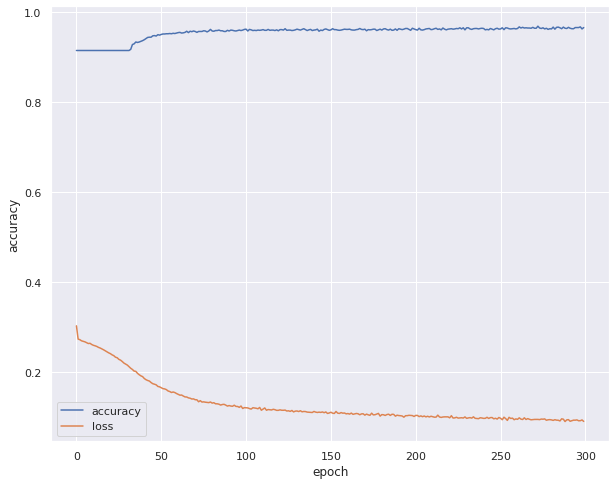

In [145]:
# plotしてみる
# pd.DataFrame(history.history)[['loss', 'accuracy']].plot()

hist_df = pd.DataFrame(history.history)
plt.figure()
hist_df[['accuracy', 'loss']].plot(figsize=(10,8))
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [146]:
print("Evaluate on test data")
results = model.evaluate(test_X, test_label, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 519 samples")
predictions = model.predict(test_X[:519])
print("predictions shape:", predictions)

Evaluate on test data
5/5 [==============================] - 0s 1ms/step - loss: 0.4879 - accuracy: 0.8054
test loss, test acc: [0.4879218637943268, 0.8053950071334839]
Generate predictions for 519 samples
predictions shape: [[9.99997735e-01]
 [3.54192555e-01]
 [5.87433279e-01]
 [2.04496682e-02]
 [1.53303713e-01]
 [8.56015563e-01]
 [8.16417694e-01]
 [2.42967010e-01]
 [6.36066318e-01]
 [5.98305345e-01]
 [7.31074214e-01]
 [9.69649494e-01]
 [8.40657055e-01]
 [3.93693477e-01]
 [6.38025999e-01]
 [8.29241455e-01]
 [7.62060583e-01]
 [3.28876257e-01]
 [5.35973370e-01]
 [4.10663009e-01]
 [2.53867507e-01]
 [6.40844107e-02]
 [6.31493747e-01]
 [3.79034847e-01]
 [1.21119887e-01]
 [3.51788044e-01]
 [3.20803463e-01]
 [2.43961602e-01]
 [4.98848140e-01]
 [8.35569620e-01]
 [3.41913819e-01]
 [1.69832021e-01]
 [4.91789311e-01]
 [3.70581508e-01]
 [1.66894972e-01]
 [3.94057333e-01]
 [1.93228036e-01]
 [1.69123352e-01]
 [2.48089612e-01]
 [4.44472045e-01]
 [2.06603438e-01]
 [4.36511040e-01]
 [2.25511134e-01]
 

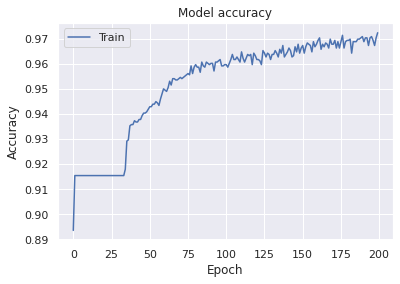

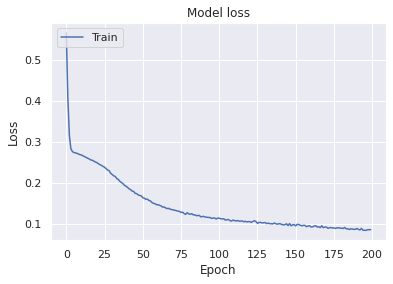

In [113]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()